In [ ]:

# pesos (en base volatilidad?)

# decay metric

# bookmarks

# feature neutralization

#float16

In [1]:
import gc
import pickle
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy import stats

import plotly.express as px
import plotly.graph_objects as go

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from data import kalman_filter, butterworth_filter

%matplotlib inline

DATAPATH = 'D:/data/ubiquant/train.csv'
CAHE_DIR = 'D:/ubiquant_cache/'

In [39]:
data = pd.read_csv(DATAPATH)
print('number of rows:',len(data))
print('number of missing values:',(data[:] == np.nan).sum())

number of opportunities: 3141410


Each trade opportunity consists on a time id, an instrument id, a target and 300 anonymised features.

In [2]:
data.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


There are 3579 instrument ids which represent financial instruments, like equity shares in a public company.  
There are 1211 time ids, probably representing days. If that's the case indeed, the training data spans several years of trading.

In [9]:
print('number of investment ids:',len(data.investment_id.unique()))
print('number of time ids:',len(data.time_id.unique()))

number of investment ids: 3579
number of time ids: 1211


Time ids range from 0 to 1219 but the number of trade opportunities for each time id is not constant.  
Ubiquant selection model reduces the number of opportunities if volatilty is high as we will see later. Some time ids don't even have any trade opportunity.

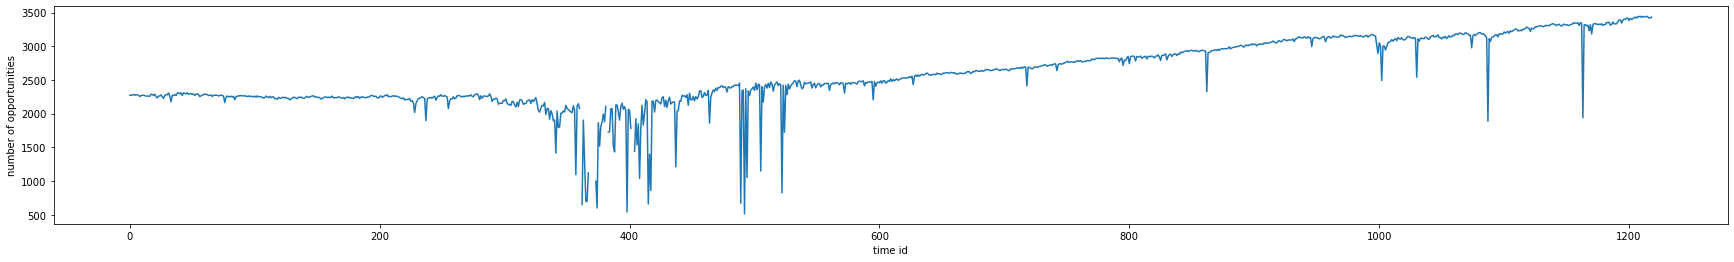

In [37]:
fig, ax1 = plt.subplots(figsize=(30, 4))
ax1.set_xlabel("time id")
ax1.set_ylabel('number of opportunities')

data.time_id.value_counts().sort_index().reindex(list(range(max(data.time_id)))).plot()

plt.show()

In [40]:
time_ids  = data.iloc[:,1].to_numpy(dtype=np.float32)
strat_ids = data.iloc[:,2].to_numpy(dtype=np.float32)
targets   = data.iloc[:,3].to_numpy(dtype=np.float32)
features  = data.iloc[:,4:].to_numpy(dtype=np.float32)

del data
gc.collect()

22393

<br>

### Target

The target distribution has positive skew and heavy tails. It likely represents future returns or something related with returns.  
The negative mean probably comes from a change in the sign of the values for anonymization.

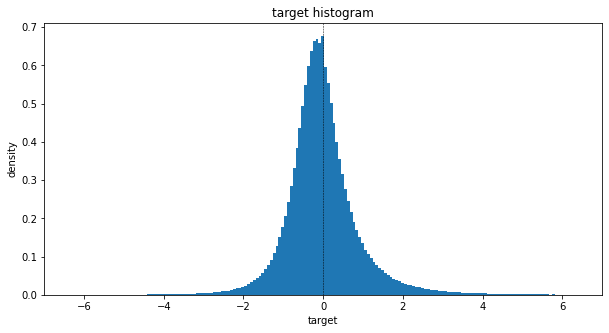

In [117]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel("target")
ax.set_ylabel("density")
ax.set_title("target histogram")

plt.hist(targets, bins=300, density=True)
plt.xlim(-7,7)
plt.axvline(0, color='black', linestyle='--',linewidth=0.5)
plt.show()

For specific time ids, the standard deviation of the targets usually range between 0.8 and 1.  
The stadandard deviation of all the targets is 0.92 (red vertical line).

In [109]:
day_targets_means = []
day_targets_stds  = []

for time_id in tqdm(np.unique(time_ids)):

    idx = time_ids==time_id
    day_targets = targets[idx]

    day_targets_means.append(np.mean(day_targets))
    day_targets_stds.append(np.std(day_targets))

100%|██████████| 1211/1211 [00:03<00:00, 380.23it/s]


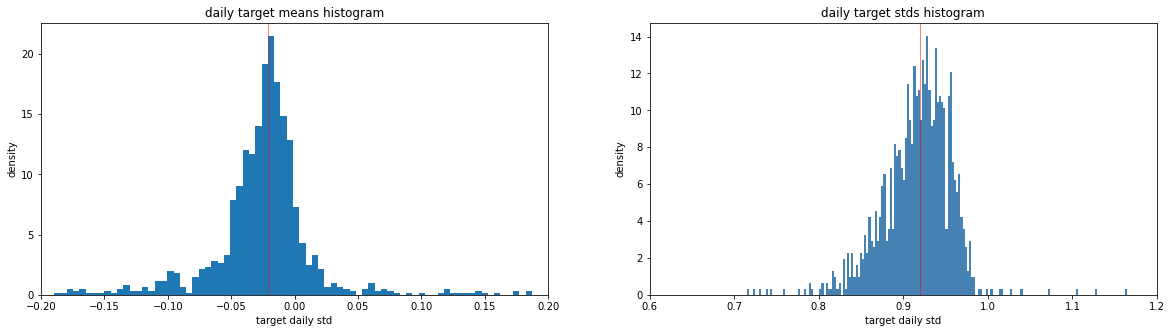

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].set_xlabel("target daily std")
ax[0].set_ylabel("density")
ax[0].set_title("daily target means histogram")
ax[0].set_xlim(-0.2,0.2)
ax[0].hist(np.stack(day_targets_means), bins=300, density=True)
ax[0].axvline(np.mean(targets), color='red', linestyle='-',linewidth=0.5)

ax[1].set_xlabel("target daily std")
ax[1].set_ylabel("density")
ax[1].set_title("daily target stds histogram")
ax[1].set_xlim(0.6,1.2)
ax[1].hist(np.stack(day_targets_stds), bins=300, density=True, color='steelblue')
ax[1].axvline(np.std(targets), color='red', linestyle='-',linewidth=0.5)

plt.show()

Around timeid=350 volatility kicks in, daily returns crumble and the number of trade opportunities selected by Ubiquant decreases substantially. (sign of returns has been flipped in the bellow plots)

In [42]:
days = np.empty((int(max(time_ids))+1,5), dtype=np.float32);  days[:] = np.nan

for time_id in tqdm(np.unique(time_ids)):

    idx = time_ids==time_id
    day_targets = targets[idx]

    days[int(time_id),0] = time_id
    days[int(time_id),1] = np.mean(day_targets)  # daily returns
    days[int(time_id),2] = np.std(day_targets)  # intraday volatility
    days[int(time_id),3] = np.nanstd(days[max(0,int(time_id)-5):int(time_id)+1,1])  # last 5 days volatility
    days[int(time_id),4] = len(day_targets)

days = pd.DataFrame(days).ffill(axis=0).to_numpy(dtype=np.float32)

100%|██████████| 1211/1211 [00:03<00:00, 361.05it/s]


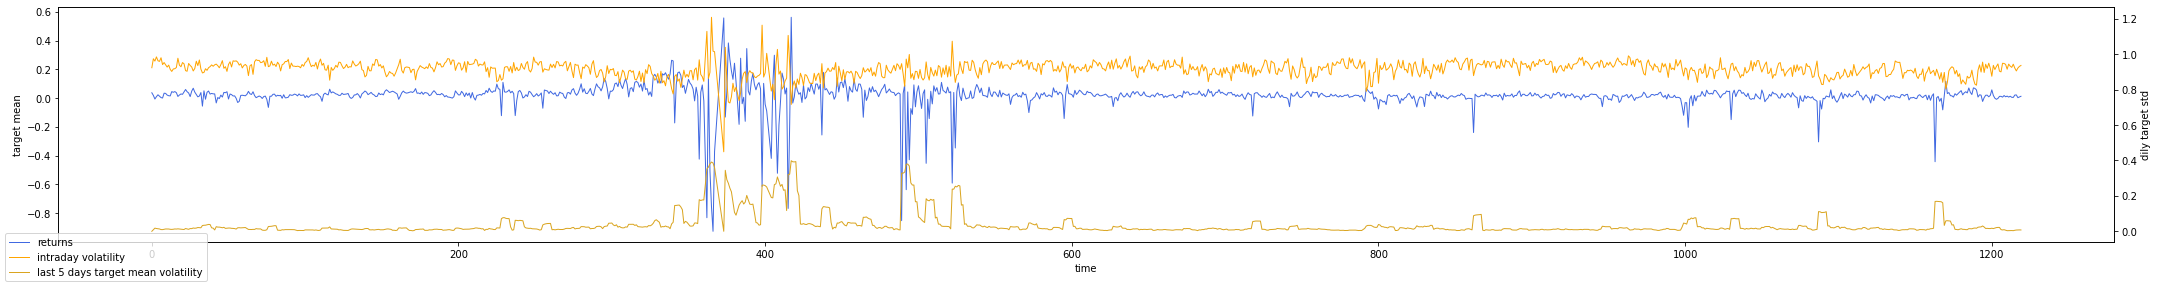

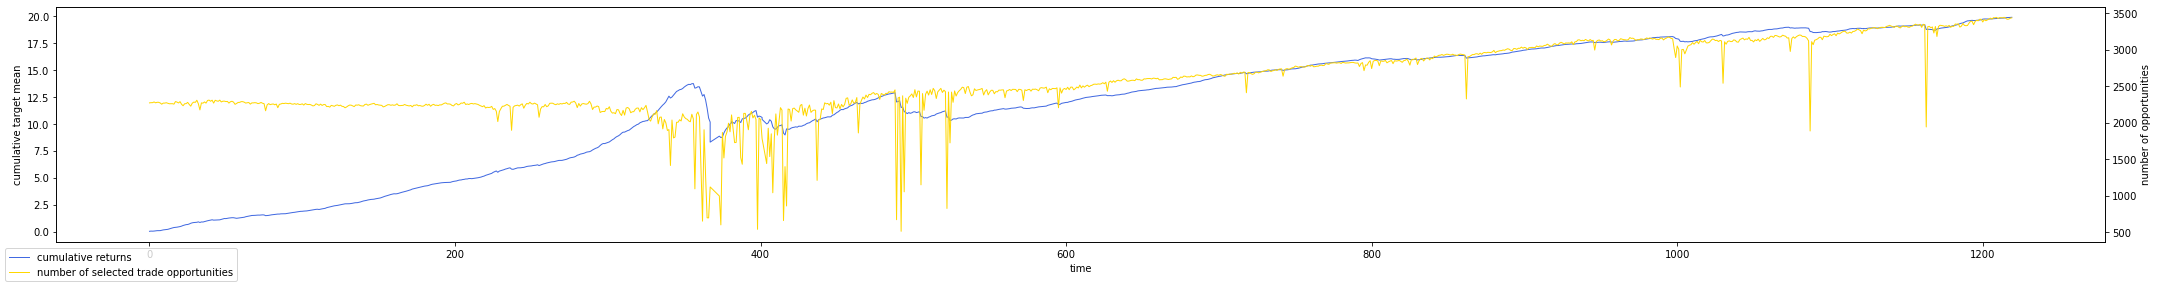

In [58]:
fig, ax1 = plt.subplots(figsize=(30, 4))

ax1.set_xlabel("time")
ax1.set_ylabel('target mean')
ax1.plot(days[:,0], -days[:,1], lw=1, color='royalblue', label='returns')

ax2 = ax1.twinx()
ax2.set_ylabel('dily target std')
ax2.plot(days[:,0], days[:,2], lw=1, color='orange', label='intraday volatility')
ax2.plot(days[:,0], days[:,3], lw=1, color='goldenrod', label='last 5 days target mean volatility')

fig.legend(loc="lower left")
fig.tight_layout()
plt.show()

##################################################################

fig, ax1 = plt.subplots(figsize=(30, 4))

ax1.set_xlabel("time")
ax1.set_ylabel('cumulative target mean')
ax1.plot(days[:,0], -days[:,1].cumsum(), lw=1, color='royalblue', label='cumulative returns')

ax2 = ax1.twinx()
ax2.set_ylabel('number of opportunities')
ax2.plot(days[:,0], days[:,4], lw=1, color='gold', label='number of selected trade opportunities')

fig.legend(loc="lower left")
fig.tight_layout()
plt.show()

Most of the instrument ids come up frequently, only a small proportion appear less than 200 times.  
Standard deviation of the target for specific instruments ranges between 0.4 and 1.4. As reference the target has standard deviation of 0.92 across all the training data.

In [46]:
strats = np.empty((int(max(strat_ids))+1,5), dtype=np.float32);  strats[:] = np.nan

for strat_id in tqdm(np.unique(strat_ids)):

    idx = strat_ids==strat_id
    strat_targets = targets[idx]

    strats[int(strat_id),0] = strat_id
    strats[int(strat_id),1] = len(strat_targets)
    strats[int(strat_id),2] = np.mean(strat_targets)
    strats[int(strat_id),3] = np.std(strat_targets)
    strats[int(strat_id),4] = np.nanmean(pd.Series(strat_targets).rolling(window=5, min_periods=1).std().to_numpy(dtype=np.float32))

strats = strats[~np.isnan(strats).any(axis=1)]

100%|██████████| 3579/3579 [00:11<00:00, 319.92it/s]


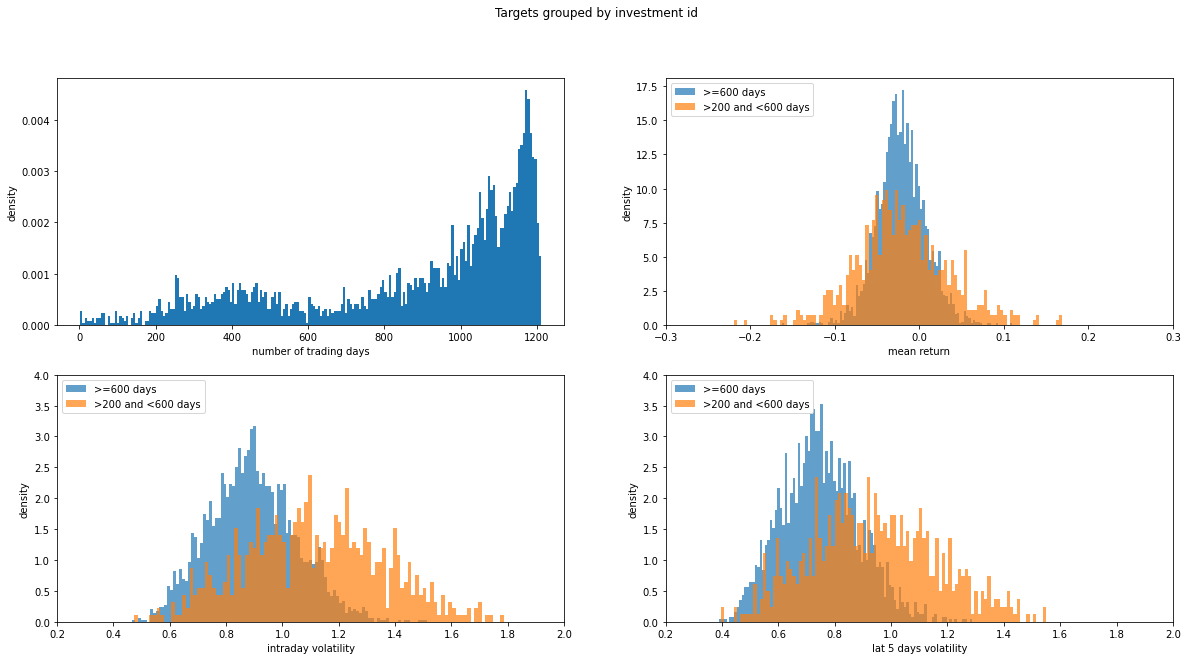

In [85]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0,0].set_xlabel('number of trading days')
ax[0,0].set_ylabel('density')
ax[0,0].hist(strats[:,1], bins=200, density=True)

repr_strats = strats[strats[:,1]>=600]
fewe_strats = strats[(strats[:,1]>200) & (strats[:,1]<600)]

ax[0,1].set_xlabel('mean return')
ax[0,1].set_ylabel('density')
ax[0,1].set_xlim(-0.3,0.3)
ax[0,1].hist(repr_strats[:,2], bins=100, density=True, alpha=0.7, label='>=600 days')
ax[0,1].hist(fewe_strats[:,2], bins=100, density=True, alpha=0.7, label='>200 and <600 days')
ax[0,1].legend(loc="upper left")

ax[1,0].set_xlabel('intraday volatility')
ax[1,0].set_ylabel('density')
ax[1,0].set_xlim(0.2,2)
ax[1,0].set_ylim(0,4)
ax[1,0].hist(repr_strats[:,3], bins=100, density=True, alpha=0.7, label='>=600 days')
ax[1,0].hist(fewe_strats[:,3], bins=100, density=True, alpha=0.7, label='>200 and <600 days')
ax[1,0].legend(loc="upper left")

ax[1,1].set_xlabel('lat 5 days volatility')
ax[1,1].set_ylabel('density')
ax[1,1].set_xlim(0.2,2)
ax[1,1].set_ylim(0,4)
ax[1,1].hist(repr_strats[:,4], bins=100, density=True, alpha=0.7, label='>=600 days')
ax[1,1].hist(fewe_strats[:,4], bins=100, density=True, alpha=0.7, label='>200 and <600 days')
ax[1,1].legend(loc="upper left")

fig.suptitle("Targets grouped by investment id")

plt.show()


<br>

### Features

In [ ]:
# normalation #TODO: notebooks kaggle

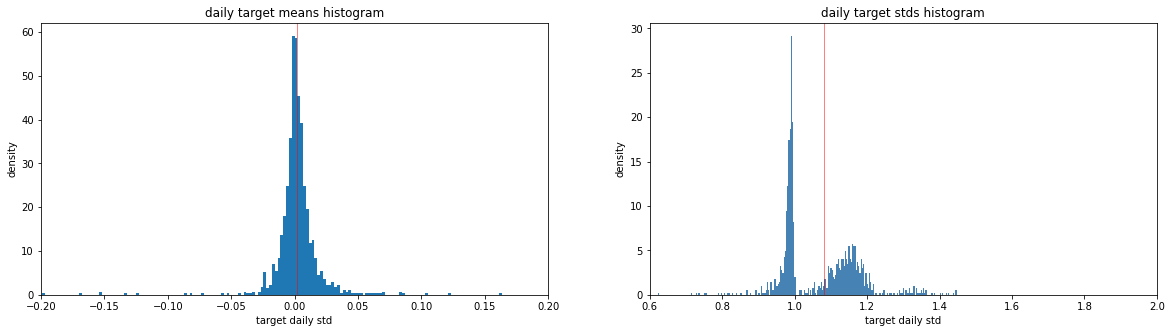

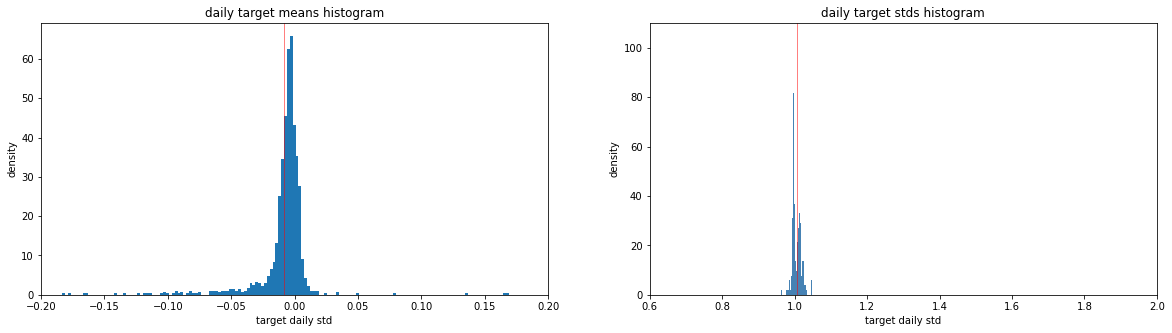

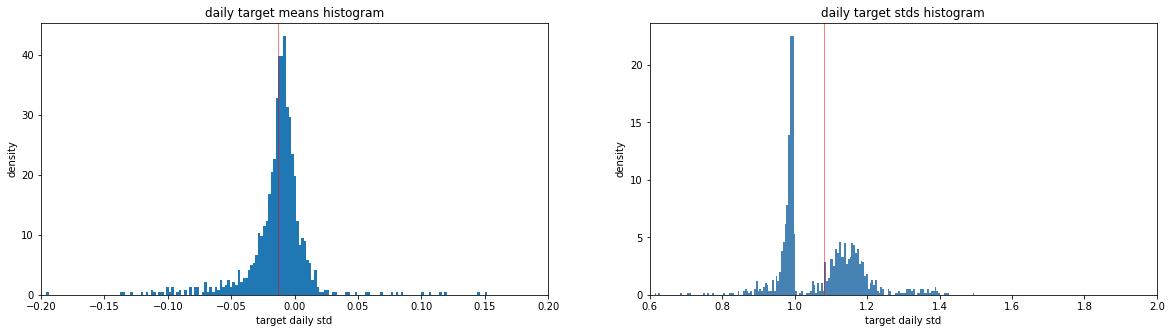

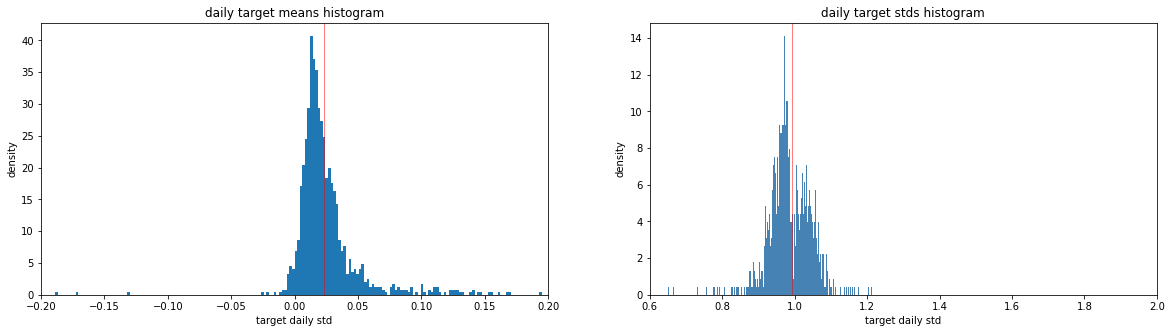

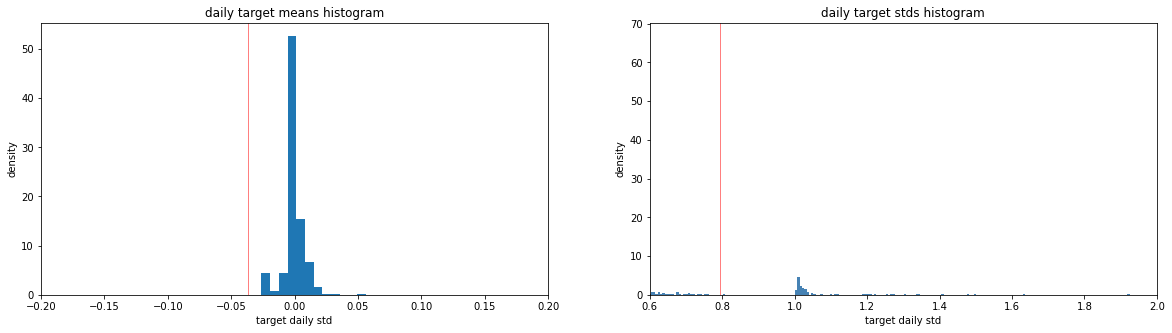

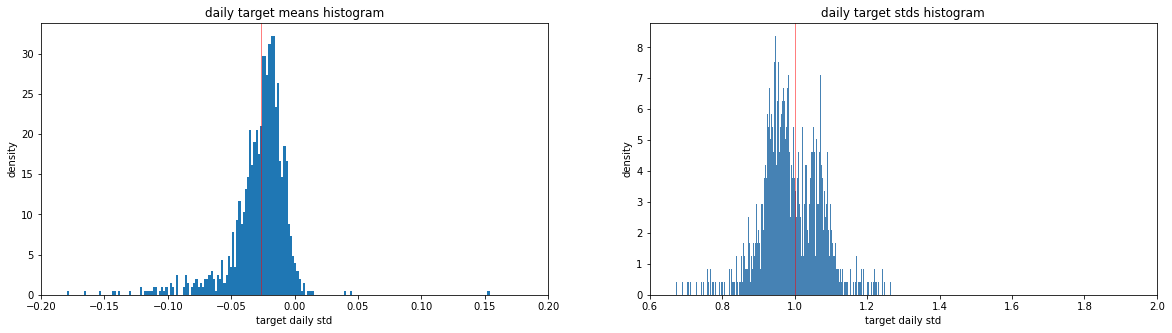

In [125]:
for i in 0,50,100,150,200,250:

    day_features_means = []
    day_features_stds = []

    for time_id in np.unique(time_ids):

        idx = time_ids==time_id
        day_features = features[idx]

        day_features_means.append(np.mean(day_features[:,i]))
        day_features_stds.append(np.std(day_features[:,i]))

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].set_xlabel("target daily std")
    ax[0].set_ylabel("density")
    ax[0].set_title("daily target means histogram")
    ax[0].set_xlim(-0.2,0.2)
    ax[0].hist(np.stack(day_features_means), bins=300, density=True)
    ax[0].axvline(np.mean(features[:,i]), color='red', linestyle='-',linewidth=0.5)

    ax[1].set_xlabel("target daily std")
    ax[1].set_ylabel("density")
    ax[1].set_title("daily target stds histogram")
    ax[1].set_xlim(0.6,2)
    ax[1].hist(np.stack(day_features_stds), bins=300, density=True, color='steelblue')
    ax[1].axvline(np.std(features[:,i]), color='red', linestyle='-',linewidth=0.5)

    plt.show()

In [134]:
corr_t = np.corrcoef(np.hstack((targets.reshape(-1,1),features)).T)[1:,0]

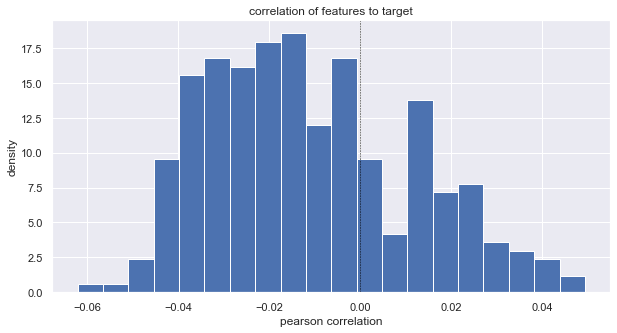

In [151]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel("pearson correlation")
ax.set_ylabel("density")
ax.set_title("correlation of features to target")

plt.hist(corr_t, bins=20, density=True)
plt.axvline(0, color='black', linestyle='--',linewidth=0.5)
plt.show()

In [170]:
pd.DataFrame(np.sort(np.abs(corr_t))[::-1][:10].round(3), np.argsort(np.abs(corr_t))[::-1][:10]).rename(columns={0: "absolute correlation to target"})

,absolute correlation to target
231,0.062
250,0.056
119,0.049
265,0.047
280,0.047
270,0.047
197,0.046
65,0.046
25,0.045
155,0.044


The relationship fetween the features and the target is very volatile. In the 

100%|██████████| 1211/1211 [00:27<00:00, 43.47it/s]


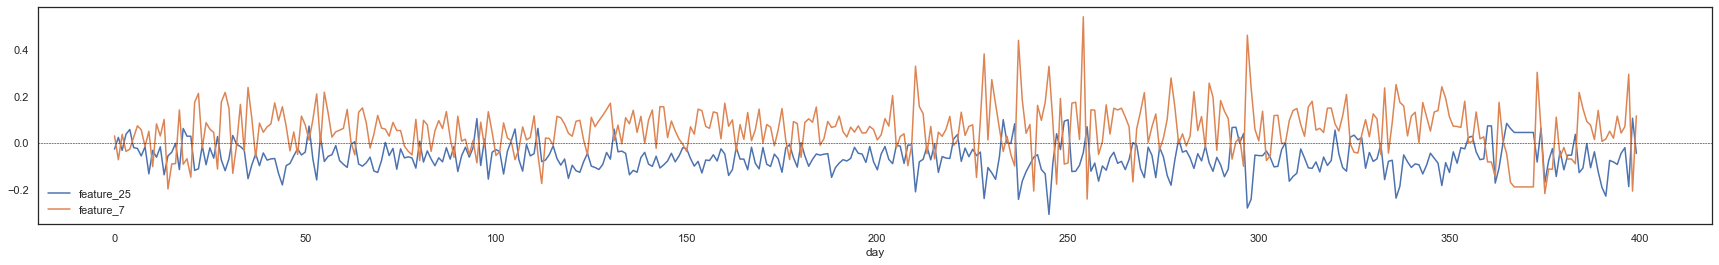

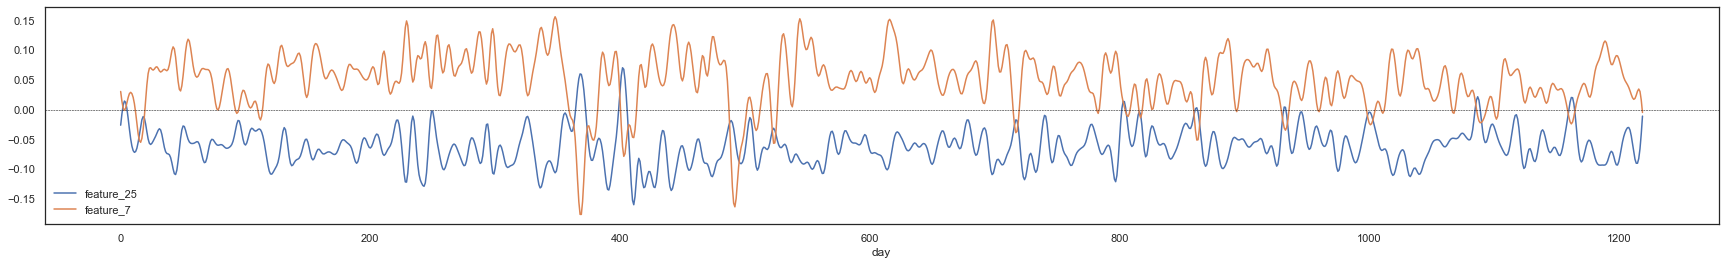

In [205]:
pears_to_target_0 = np.empty((int(max(time_ids))+1,1), dtype=np.float32);  pears_to_target_0[:] = np.nan
pears_to_target_1 = np.empty((int(max(time_ids))+1,1), dtype=np.float32);  pears_to_target_1[:] = np.nan

#74, 153
#25, 7

for time_id in tqdm(np.unique(time_ids)):

    pears0 = np.corrcoef(np.hstack((targets[time_id == time_ids].reshape(-1,1),features[time_id == time_ids,231].reshape(-1,1))).T)[1:,0]
    pears_to_target_0[int(time_id)] = np.nan_to_num(pears0, posinf=0., neginf=0.).flatten()

    pears1 = np.corrcoef(np.hstack((targets[time_id == time_ids].reshape(-1,1),features[time_id == time_ids,119].reshape(-1,1))).T)[1:,0]
    pears_to_target_1[int(time_id)] = np.nan_to_num(pears1, posinf=0., neginf=0.).flatten()

pears_to_target_0 = pd.DataFrame(pears_to_target_0).ffill(axis=0).to_numpy(dtype=np.float32)
pears_to_target_1 = pd.DataFrame(pears_to_target_1).ffill(axis=0).to_numpy(dtype=np.float32)

#################################################################

fig, axo = plt.subplots(1,1,figsize=(30,4))

ma = 400

plt.plot(range(ma), pears_to_target_0[:ma])
plt.plot(range(ma), pears_to_target_1[:ma])
axo.axhline(0,color='black',ls='--',linewidth=0.5)
axo.legend(loc='lower left', frameon=False, labels=('feature_25','feature_7'))
axo.set_xlabel('day')

plt.show()

#################################################################

fig, axo = plt.subplots(1,1,figsize=(30,4))

ma = len(pears_to_target_0)

plt.plot(range(ma), butterworth_filter(pears_to_target_0.squeeze()[:ma]))
plt.plot(range(ma), butterworth_filter(pears_to_target_1.squeeze()[:ma]))
axo.axhline(0,color='black',ls='--',linewidth=0.5)
axo.legend(loc='lower left', frameon=False, labels=('feature_25','feature_7'))
axo.set_xlabel('day')

plt.show()

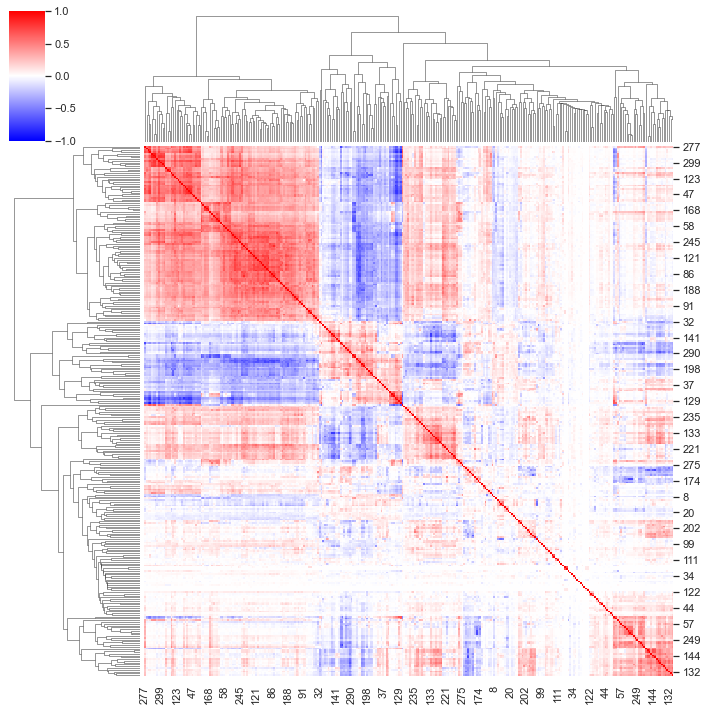

In [204]:
corr_f2 = np.corrcoef(features.T)

sns.set_style(style='white')
sns.clustermap(corr_f2, cmap='bwr', vmin=-1, vmax=1)
plt.show()

<br>

### Feature engineering

In [207]:
max_time_id = int(max(time_ids))+1
day_means = np.empty((max_time_id,features.shape[1]), dtype=np.float32);  day_means[:] = np.nan

for time_id in np.unique(time_ids):
    day_means = np.mean(features[time_ids==time_id],axis=0)

day_means = day_means[~np.isnan(day_means).any(axis=1)]

AxisError: axis 1 is out of bounds for array of dimension 1

pca explained var: 0.9498234361871511


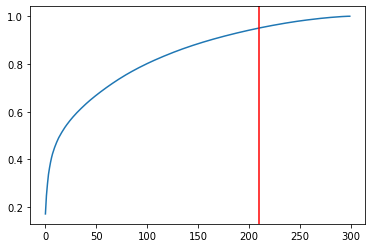

In [4]:
pca_feats = PCA(n_components=300)
pca_feats.fit(features)

print('pca explained var:',pca_feats.explained_variance_ratio_[:210].sum())

plt.plot(np.cumsum(pca_feats.explained_variance_ratio_))
plt.axvline(x=210, color='r', linestyle='-')
plt.show()

pca explained var: 0.9739499


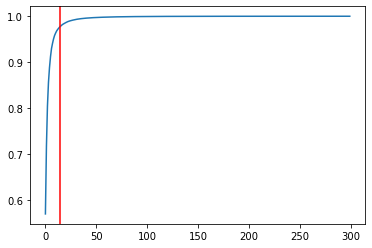

In [5]:
pca_feats_day_means = PCA(n_components=300)
pca_feats_day_means.fit(day_means)

print('pca explained var:',pca_feats_day_means.explained_variance_ratio_[:14].sum())

plt.plot(np.cumsum(pca_feats_day_means.explained_variance_ratio_))
plt.axvline(x=14, color='r', linestyle='-')
plt.show()

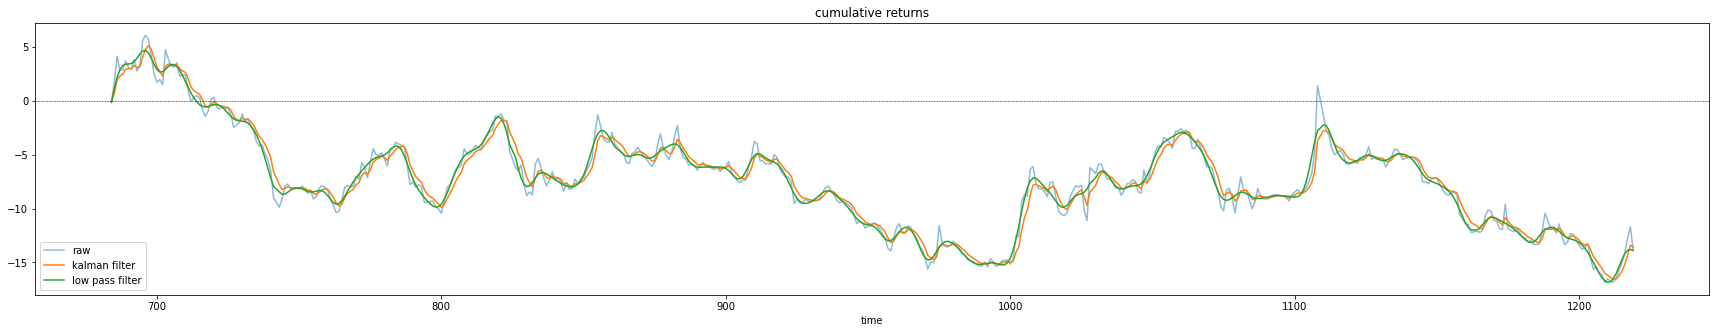

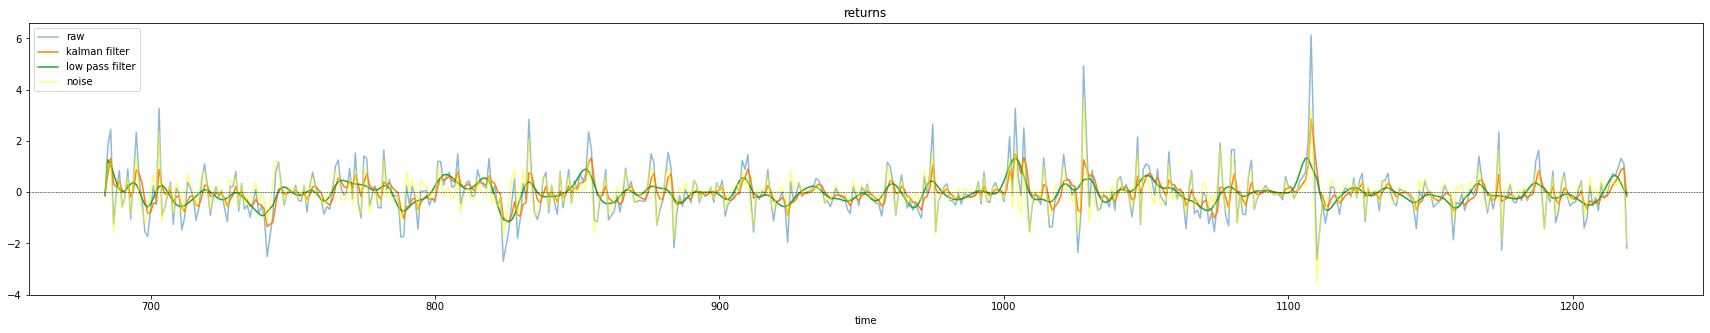

In [50]:
strat_id = 122
strat_targets = targets[strat_ids==strat_id]
strat_times_ids = time_ids[strat_ids==strat_id]

cum_kalman = kalman_filter(strat_targets.cumsum(),0.2)
cum_lowpass = butterworth_filter(strat_targets.cumsum(),0.2)

# for i in range(8):
#     print(np.corrcoef((strat_targets,np.roll(strat_targets,i)))[0,1])

fig, ax = plt.subplots(figsize=(30, 5))
ax.set_xlabel("time")
ax.set_title("cumulative returns")

plt.plot(strat_times_ids, strat_targets.cumsum(), alpha=0.5, label='raw')
plt.plot(strat_times_ids, cum_kalman, label='kalman filter')
plt.plot(strat_times_ids, cum_lowpass, label='low pass filter')

plt.legend(loc="lower left")
plt.axhline(0,color='black',ls='--',linewidth=0.5)

#################################################################

fig, ax = plt.subplots(figsize=(30, 5))
ax.set_xlabel("time")
ax.set_title("returns")

plt.plot(strat_times_ids, strat_targets, alpha=0.5, label='raw')
# plt.plot(strat_times_ids, np.diff(strat_targets.cumsum(),prepend=0),ls='--',alpha=0.5, label='raw')
plt.plot(strat_times_ids, np.diff(cum_kalman,prepend=0), label='kalman filter')
plt.plot(strat_times_ids, np.diff(cum_lowpass,prepend=0), label='low pass filter')
plt.plot(strat_times_ids, strat_targets - np.diff(cum_kalman,prepend=0), alpha=0.5, label='noise', color='yellow')

plt.legend(loc="upper left")
plt.axhline(0,color='black',ls='--',linewidth=0.5)

In [17]:
features_de = np.clip(np.round(features[:,:3] * 3), -2*3, 2*3)
targets_de  = 1.*(targets>0)

strat_corrs = np.empty((int(max(strat_ids))+1,3), dtype=np.float32); strat_corrs[:] = np.nan
strat_index = np.array(range(len(strat_corrs)))

print('computing correlations of strat features to target...')
for strat_id in tqdm(np.unique(strat_ids)):

    feats_stratgroup_de = features_de[strat_ids==strat_id]
    targs_stratgroup_de = targets_de[strat_ids==strat_id]

    corrs = np.corrcoef(np.hstack((targs_stratgroup_de.reshape(-1,1),feats_stratgroup_de)).T)[1:,0]
    strat_corrs[int(strat_id)] = np.nan_to_num(corrs, posinf=0., neginf=0.)
    strat_index[int(strat_id)] = strat_id

computing correlations of strat features to target...


  2%|▏         | 72/3579 [00:00<00:39, 88.59it/s]C:\Users\codef\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\codef\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 3579/3579 [00:41<00:00, 86.72it/s]


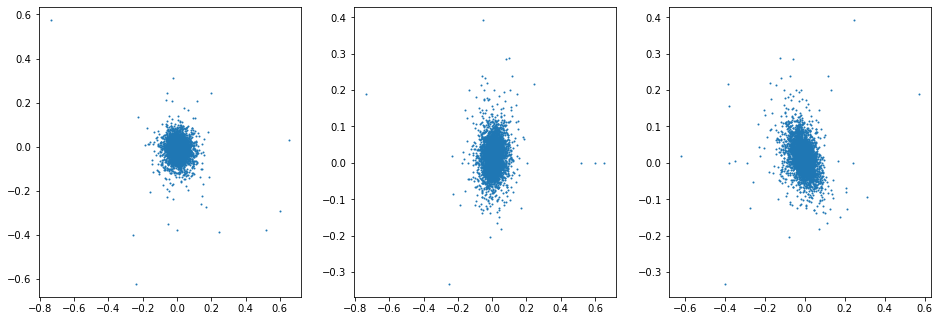

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(16, 16/3))

# pal = sns.color_palette()

ax[0].scatter(strat_corrs[:,0],strat_corrs[:,1], s=1,)
ax[1].scatter(strat_corrs[:,0],strat_corrs[:,2], s=1)
ax[2].scatter(strat_corrs[:,1],strat_corrs[:,2], s=1)

In [4]:
print('scaling...')
features_p = StandardScaler().fit_transform(features)
print('PCA...')
features_p = PCA(n_components=210).fit_transform(features_p)

scaling...
PCA...


In [5]:
num_pcs = 81

max_time_id = int(max(time_ids))+1
time_index = np.array(range(max_time_id))
day_means = np.empty((max_time_id,features_p.shape[1]), dtype=np.float32);  day_means[:] = np.nan
pears_to_target = np.empty((max_time_id,num_pcs), dtype=np.float32);  pears_to_target[:] = np.nan
spear_to_target = np.empty((max_time_id,num_pcs), dtype=np.float32);  spear_to_target[:] = np.nan

features_de = np.clip(np.round(features_p[:,:num_pcs] * 3), -2*3, 2*3)
targets_de  = 1.*(targets>0)

print('computing correlations...')
for time_id in tqdm(np.unique(time_ids)):

    day_means[int(time_id)] = np.nan_to_num(np.mean(features_p[time_ids==time_id],axis=0), posinf=0., neginf=0.)

    features_daygroup_de = features_de[time_ids==time_id]
    targets_daygroup_de  = targets_de[time_ids==time_id]

    pears = np.corrcoef(np.hstack((targets_daygroup_de.reshape(-1,1),features_daygroup_de)).T)[1:,0]
    spear = stats.spearmanr(np.hstack((targets_daygroup_de.reshape(-1,1),features_daygroup_de)))[0][1:,0].astype(np.float32)

    pears_to_target[int(time_id)] = np.nan_to_num(pears, posinf=0., neginf=0.).flatten()
    spear_to_target[int(time_id)] = np.nan_to_num(spear, posinf=0., neginf=0.).flatten()

day_means = pd.DataFrame(day_means).ffill(axis=0).to_numpy(dtype=np.float32)
pears_to_target = pd.DataFrame(pears_to_target).ffill(axis=0).to_numpy(dtype=np.float32)
spear_to_target = pd.DataFrame(spear_to_target).ffill(axis=0).to_numpy(dtype=np.float32)

spear_to_target = pears_to_target - spear_to_target

computing correlations...


100%|██████████| 1211/1211 [00:56<00:00, 21.40it/s]


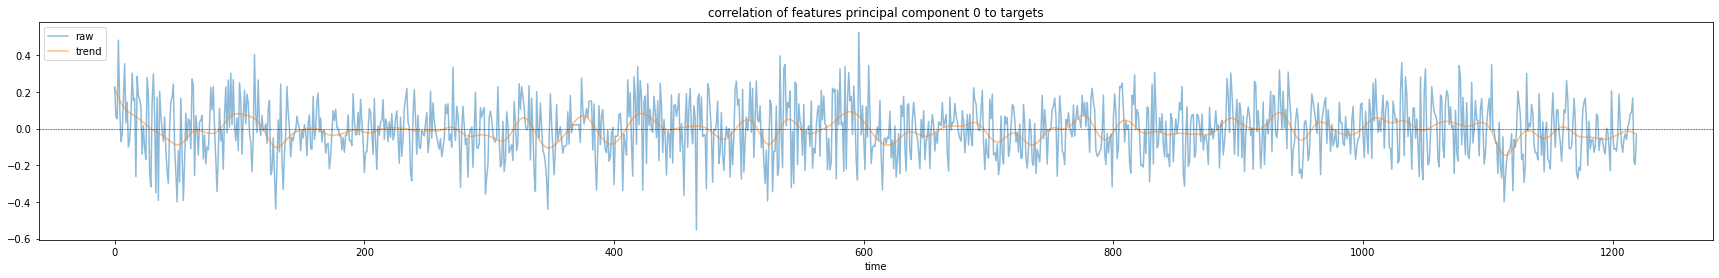

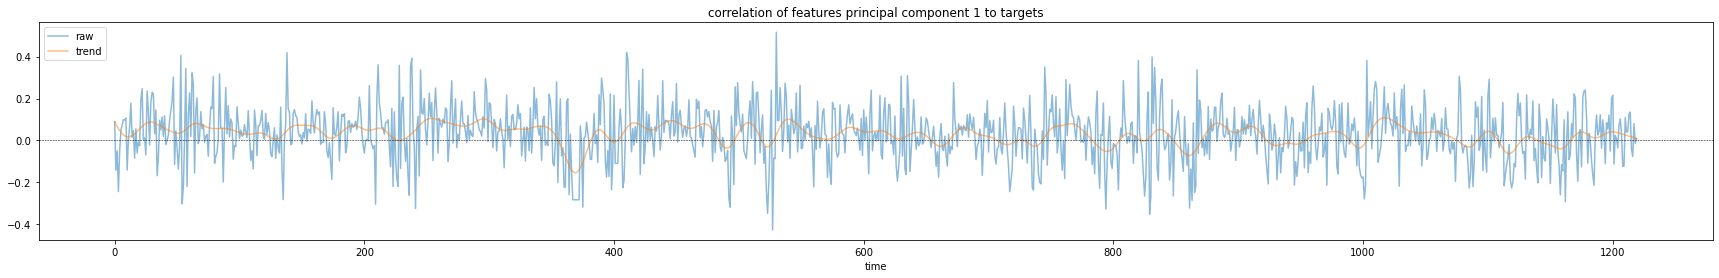

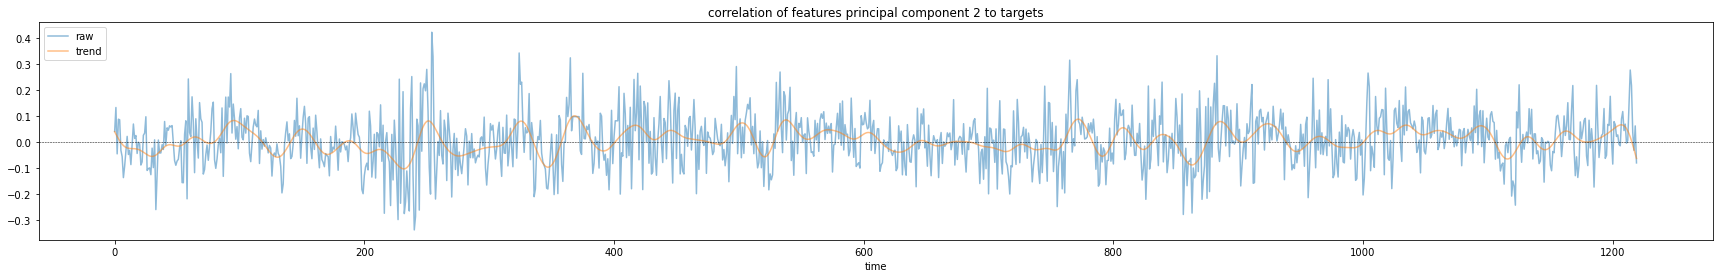

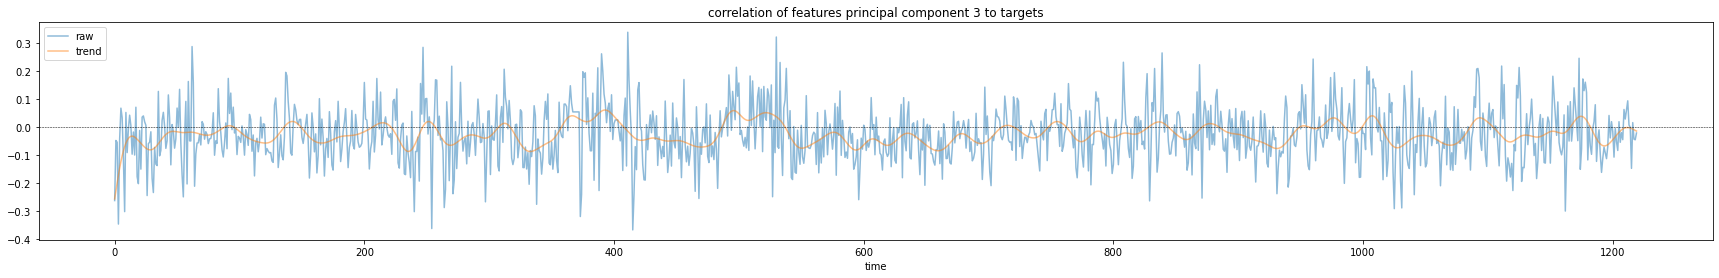

In [6]:
for i in range(4):

    fig, ax = plt.subplots(figsize=(30, 4))
    ax.set_xlabel("time")
    ax.set_title("correlation of features principal component {} to targets".format(i))

    lowpass = butterworth_filter(pears_to_target[:,i],0.07)

    plt.plot(range(len(pears_to_target)), pears_to_target[:,i], alpha=0.5, label='raw')
    plt.plot(range(len(pears_to_target)), lowpass, alpha=0.5, label='trend')

    plt.legend(loc="upper left")
    plt.axhline(0,color='black',ls='--',linewidth=0.5)

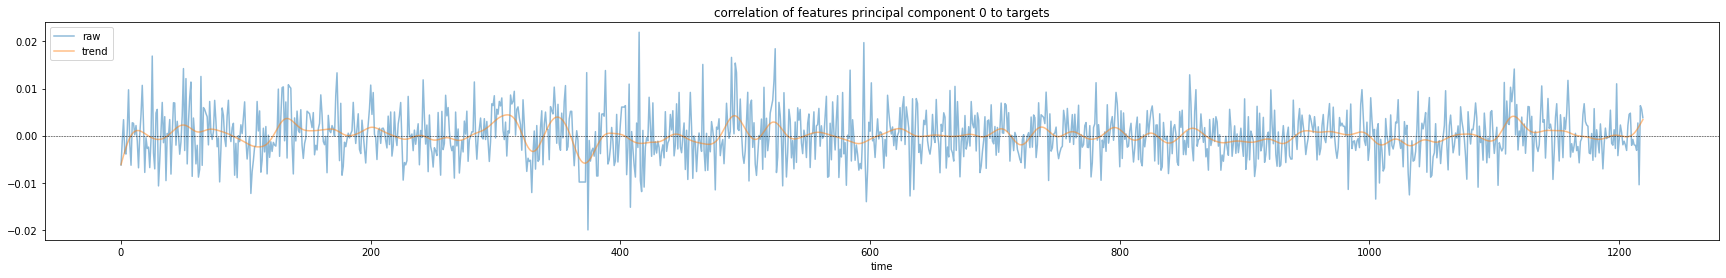

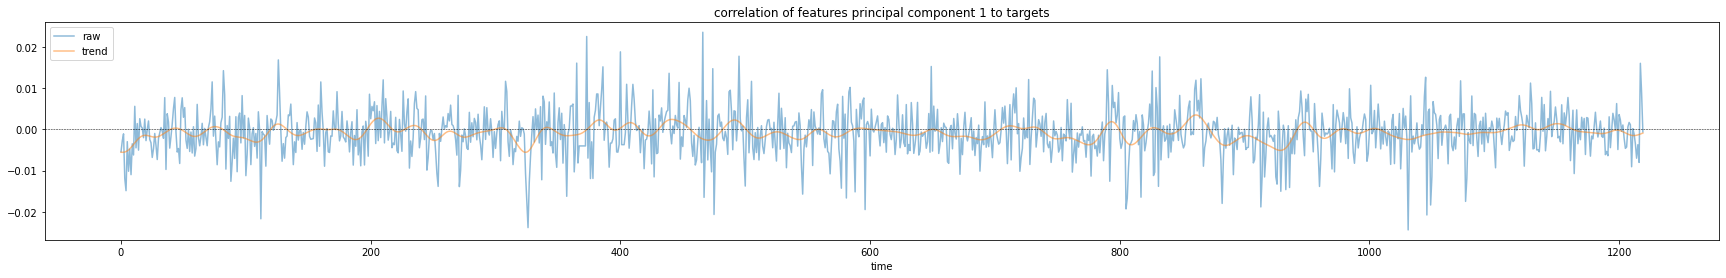

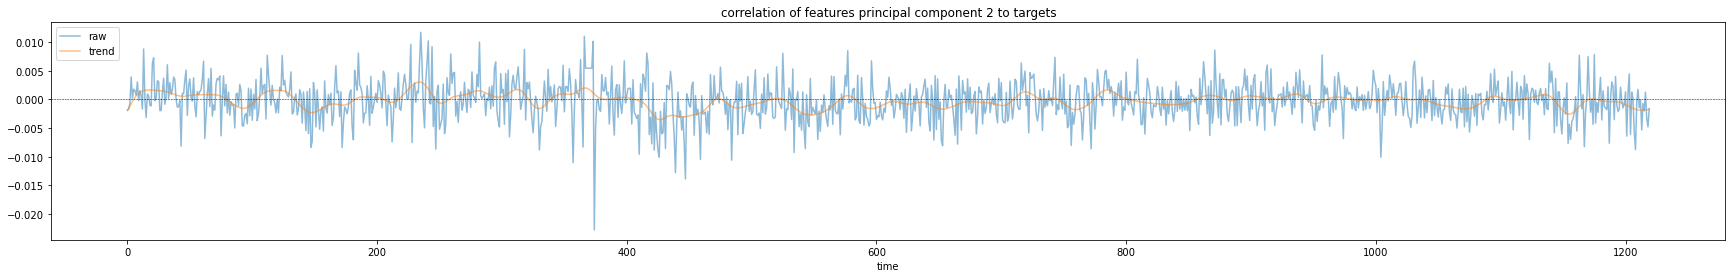

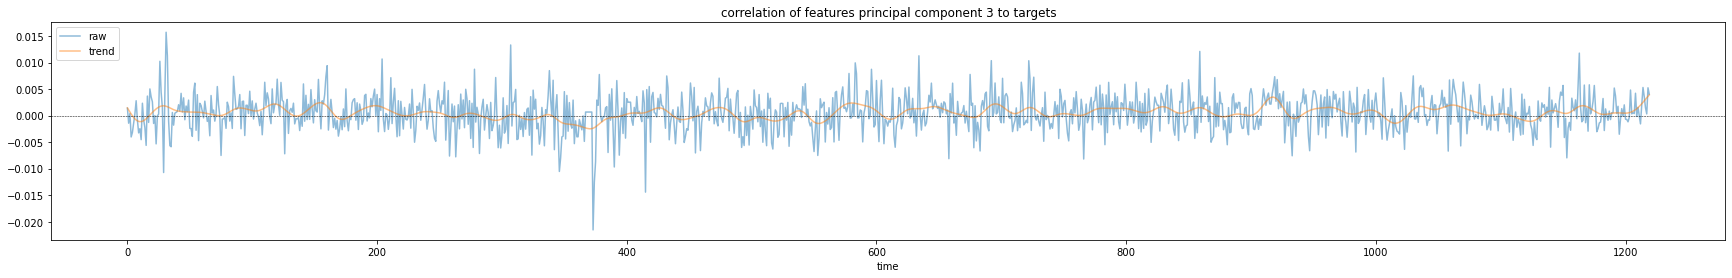

In [9]:
for i in range(4):

    fig, ax = plt.subplots(figsize=(30, 4))
    ax.set_xlabel("time")
    ax.set_title("correlation of features principal component {} to targets".format(i))

    lowpass = butterworth_filter(spear_to_target[:,i],0.07)

    plt.plot(range(len(spear_to_target)), spear_to_target[:,i], alpha=0.5, label='raw')
    plt.plot(range(len(spear_to_target)), lowpass, alpha=0.5, label='trend')

    plt.legend(loc="upper left")
    plt.axhline(0,color='black',ls='--',linewidth=0.5)

In [10]:
file_path = CAHE_DIR+'features_EVAL.pkl'
with open(file_path,'rb') as f:
    day_corrs = pickle.load(f).astype(np.float32)[:,210+6:210+6+4]

In [11]:
max_time_id = int(max(time_ids))+1
day_corrs_agg = np.empty((max_time_id,day_corrs.shape[1]), dtype=np.float32);  day_corrs_agg[:] = np.nan

for time_id in tqdm(np.unique(time_ids)):
    day_corrs_agg[int(time_id)] = day_corrs[int(time_id)==time_ids][0]

day_corrs_agg = pd.DataFrame(day_corrs_agg).ffill(axis=0).to_numpy(dtype=np.float32)

100%|██████████| 1211/1211 [00:08<00:00, 150.42it/s]


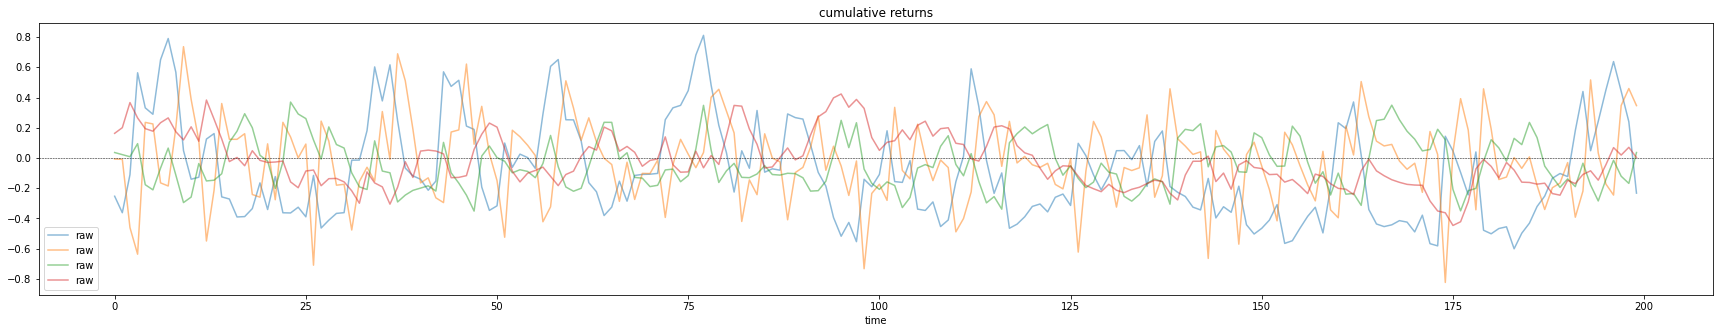

In [33]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_xlabel("time")
ax.set_title("cumulative returns")

ma = 200

plt.plot(range(ma), day_corrs_agg[:ma,0], alpha=0.5, label='raw')
plt.plot(range(ma), day_corrs_agg[:ma,1], alpha=0.5, label='raw')
plt.plot(range(ma), day_corrs_agg[:ma,2], alpha=0.5, label='raw')
plt.plot(range(ma), day_corrs_agg[:ma,3], alpha=0.5, label='raw')

plt.legend(loc="lower left")
plt.axhline(0,color='black',ls='--',linewidth=0.5)

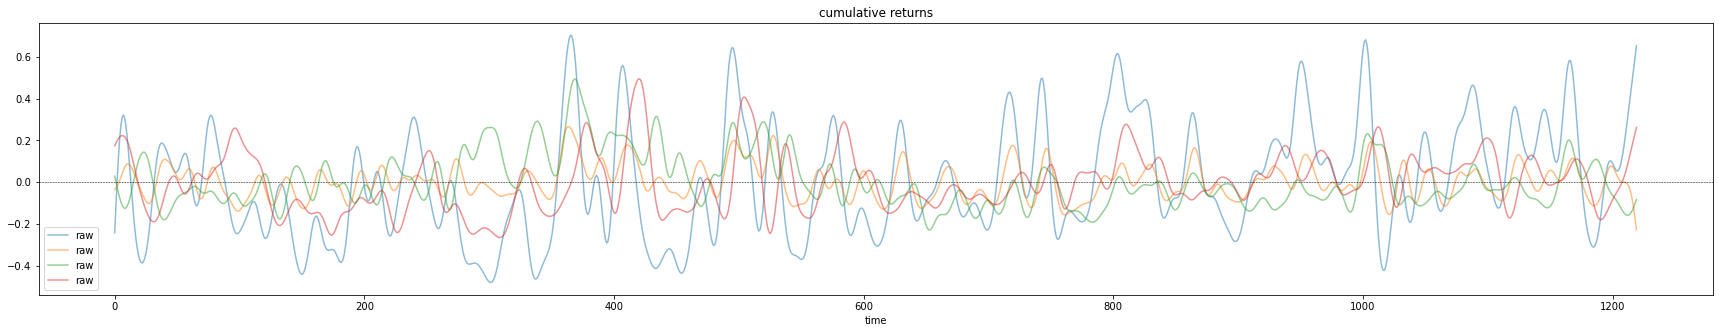

In [32]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_xlabel("time")
ax.set_title("cumulative returns")

ma = len(day_corrs_agg)

plt.plot(range(ma), butterworth_filter(day_corrs_agg[:ma,0],0.1), alpha=0.5, label='raw')
plt.plot(range(ma), butterworth_filter(day_corrs_agg[:ma,1],0.1), alpha=0.5, label='raw')
plt.plot(range(ma), butterworth_filter(day_corrs_agg[:ma,2],0.1), alpha=0.5, label='raw')
plt.plot(range(ma), butterworth_filter(day_corrs_agg[:ma,3],0.1), alpha=0.5, label='raw')

plt.legend(loc="lower left")
plt.axhline(0,color='black',ls='--',linewidth=0.5)

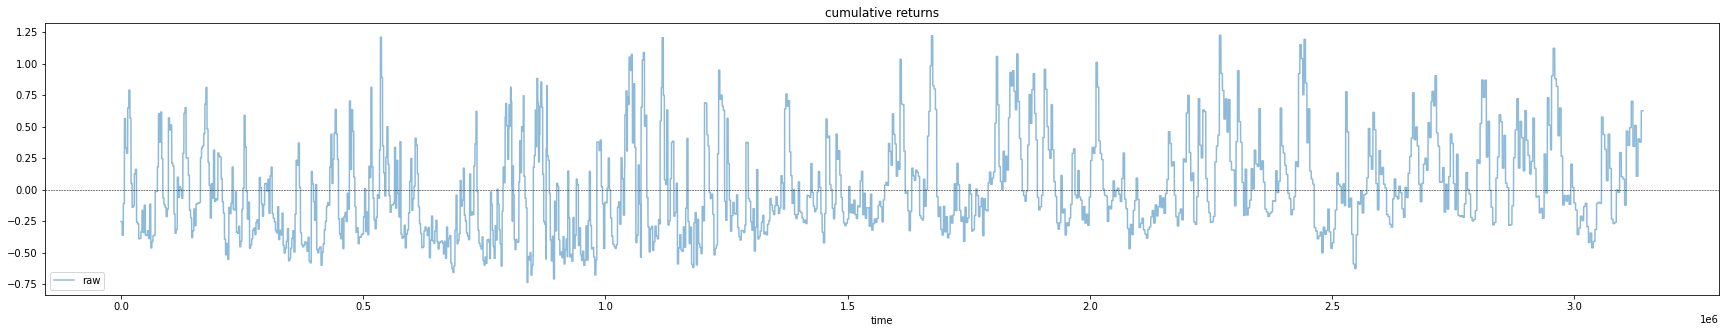

In [4]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_xlabel("time")
ax.set_title("cumulative returns")

plt.plot(range(len(day_corrs)), day_corrs, alpha=0.5, label='raw')

plt.legend(loc="lower left")
plt.axhline(0,color='black',ls='--',linewidth=0.5)

In [ ]:
#TODO: filosofia de overfitting

In [67]:
with open(CAHE_DIR+'corrs_strat.pkl','rb') as f:
    d = pickle.load(f).astype(np.float32)
    stra_corrs_lens = d[:,1]
    stra_corrs = d[:,2:]

stra_corrs.shape, np.median(np.abs(stra_corrs))

((3579, 20), 0.09493831)

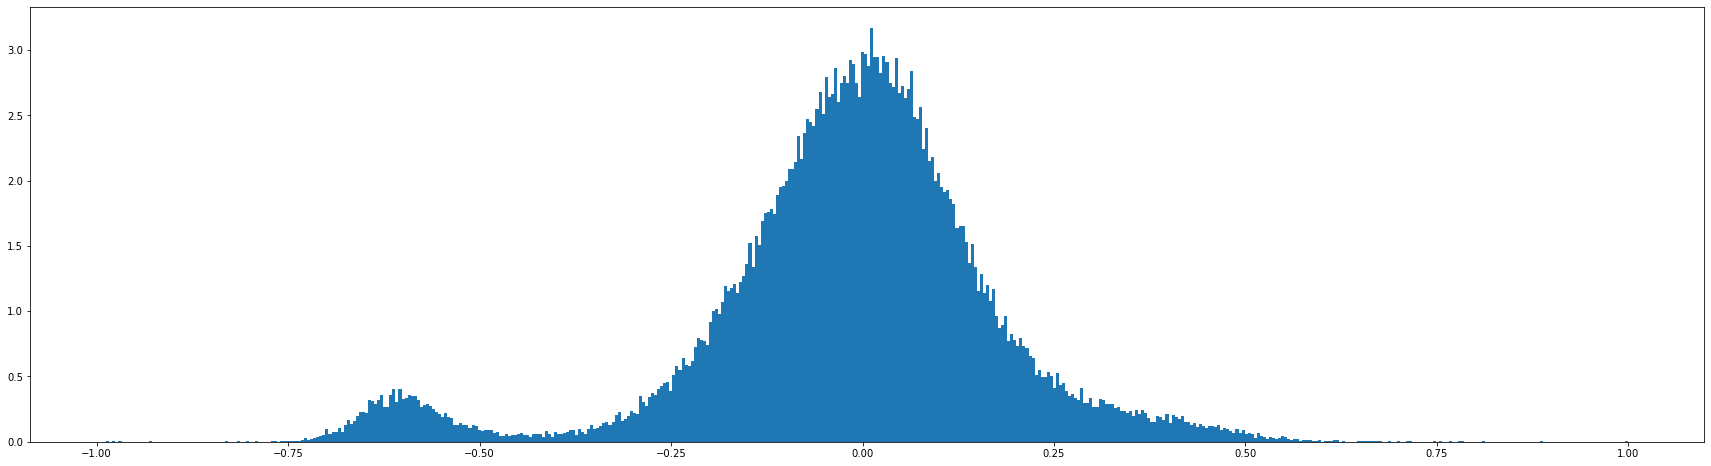

In [70]:
fig, ax = plt.subplots(figsize=(30, 8))

plt.hist(stra_corrs.flatten(), bins=500, density=True)
#plt.xlim(-0.5,0.5)
#plt.axvline(-0.037, color='r', linestyle='-')
plt.show()

In [63]:
# stra_corrs = np.clip(stra_corrs, -0.2, 0.2)
stra_corrs = stra_corrs[stra_corrs_lens > 600]
stra_corrs = stra_corrs[IsolationForest(random_state=0).fit_predict(stra_corrs)==1]

stra_corrs.shape

(2592, 20)